In [ ]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. Import Data

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Project 5 Customer Segmentation/Online Retail.xlsx')

In [ ]:
df = df[df.CustomerID.notnull()]

In [ ]:
np.random.seed(306)
df = df.sample(frac = .3).reset_index(drop = True)
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,542401,22502,PICNIC BASKET WICKER SMALL,2,2011-01-27 15:51:00,5.95,14541.0,United Kingdom
1,542231,22726,ALARM CLOCK BAKELIKE GREEN,2,2011-01-26 13:40:00,3.75,16714.0,United Kingdom
2,556956,22090,PAPER BUNTING RETROSPOT,40,2011-06-16 09:04:00,2.55,13694.0,United Kingdom
3,573874,23581,JUMBO BAG PAISLEY PARK,10,2011-11-01 12:45:00,2.08,13868.0,United Kingdom
4,580742,23343,JUMBO BAG VINTAGE CHRISTMAS,200,2011-12-06 09:30:00,1.75,13694.0,United Kingdom


In [ ]:
#extract year, month and day
df['InvoiceDate'] = df.InvoiceDate.apply( lambda x: dt.datetime(x.year, x.month, x.day))
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,542401,22502,PICNIC BASKET WICKER SMALL,2,2011-01-27,5.95,14541.0,United Kingdom
1,542231,22726,ALARM CLOCK BAKELIKE GREEN,2,2011-01-26,3.75,16714.0,United Kingdom
2,556956,22090,PAPER BUNTING RETROSPOT,40,2011-06-16,2.55,13694.0,United Kingdom
3,573874,23581,JUMBO BAG PAISLEY PARK,10,2011-11-01,2.08,13868.0,United Kingdom
4,580742,23343,JUMBO BAG VINTAGE CHRISTMAS,200,2011-12-06,1.75,13694.0,United Kingdom


In [ ]:
#number of unique users
df.CustomerID.nunique()

4222

# 2. RFM values
RFM (Recency, Frequency, Monetary) is a very Simple Technique that we can apply it very easy and get the super useful analysis for our Customer Segmentation. Recency is days since the customers made the last purchase and by definition, the lower it is the better. Frequency is the number of transaction in the last 12 months. Monetary value is the total amout of money the customers spent in the last 12 months

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,542401,22502,PICNIC BASKET WICKER SMALL,2,2011-01-27,5.95,14541.0,United Kingdom
1,542231,22726,ALARM CLOCK BAKELIKE GREEN,2,2011-01-26,3.75,16714.0,United Kingdom
2,556956,22090,PAPER BUNTING RETROSPOT,40,2011-06-16,2.55,13694.0,United Kingdom
3,573874,23581,JUMBO BAG PAISLEY PARK,10,2011-11-01,2.08,13868.0,United Kingdom
4,580742,23343,JUMBO BAG VINTAGE CHRISTMAS,200,2011-12-06,1.75,13694.0,United Kingdom


The last day of purchase in total is 09 DEC, 2011. To calculate the day periods, let's set one day after the last one, or 10 DEC as a pin date. We will cound the diff days with pin_date.


In [ ]:
print('Min: {}, Max: {}'.format(min(df.InvoiceDate), max(df.InvoiceDate)))

Min: 2010-12-01 00:00:00, Max: 2011-12-09 00:00:00


In [ ]:
pin_date = max(df.InvoiceDate) + dt.timedelta(1)
pin_date

Timestamp('2011-12-10 00:00:00')

In [ ]:
# create total spendings
df['TotalSum'] = df.Quantity * df.UnitPrice
df['TotalSum']

0          11.90
1           7.50
2         102.00
3          20.80
4         350.00
           ...  
122044      1.70
122045      0.84
122046      3.75
122047      3.48
122048     18.75
Name: TotalSum, Length: 122049, dtype: float64

In [ ]:
# calculating rfm values
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate' : lambda x: (pin_date - x.max()).days,
    'InvoiceNo' : 'count',
    'TotalSum' : 'sum'})
rfm

,InvoiceDate,InvoiceNo,TotalSum
CustomerID,,,
12347.0,3,45,980.10
12348.0,249,9,728.88
12349.0,19,25,486.87
12350.0,311,3,45.70
12352.0,37,32,1353.48
...,...,...,...
18280.0,278,1,17.70
18281.0,181,2,21.99
18282.0,8,2,30.70


In [ ]:
#rename columns
rfm.rename(columns = {'InvoiceDate' : 'Recency',
                      'InvoiceNo' : 'Frequency',
                      'TotalSum': 'Monetary'}, inplace = True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,3,45,980.10
12348.0,249,9,728.88
12349.0,19,25,486.87
12350.0,311,3,45.70
12352.0,37,32,1353.48


As the three columns are grouped by customers and count the days from the max date value, Recency is the days since the last purchase of a customer. Frequency is the number of purchases of a customer and Monetary is the total amount of spend of a customer.

# RFM quartiles
Let's group the customers based on Recency and Frequency. We will use quantile values to get three equal percentile groups an then make three separate gruops. As the lower Recency value is the better, we will label them in decreasing order.

In [ ]:
# create labels and assign them to tree percentile groups
r_labels = range(4, 0, -1)
r_groups = pd.qcut(rfm.Recency, q = 4, labels = r_labels)

f_labels = range(1, 5)
f_groups = pd.qcut(rfm.Frequency, q = 4, labels = f_labels)

m_labels = range(1, 5)
m_groups = pd.qcut(rfm.Monetary, q = 4, labels = m_labels)

r_groups.head()

CustomerID
12347.0    4
12348.0    1
12349.0    3
12350.0    1
12352.0    3
Name: Recency, dtype: category
Categories (4, int64): [4 < 3 < 2 < 1]

In [ ]:
#make a new label for group values

rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values

In [ ]:
# sum up the three columns
rfm['RFM_Segment'] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12347.0,3,45,980.10,4,4,4,4.04.04.0,12
12348.0,249,9,728.88,1,2,4,1.02.04.0,7
12349.0,19,25,486.87,3,3,3,3.03.03.0,9
12350.0,311,3,45.70,1,1,1,1.01.01.0,3
12352.0,37,32,1353.48,3,3,4,3.03.04.0,10


With this value, we can go further analysis such as what is the average values for each RFM values or leveling customers in total RFM score.


In [ ]:
# calculate averae values for each RFM_score
rfm_agg = rfm.groupby('RFM_Score').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary' : ['mean', 'count']
})

rfm_agg.round(2).head()

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3          259.26      2.92   -57.47   409
4          173.08      4.48    59.97   372
5          144.55      6.52   106.50   495
6          104.96      9.25   191.84   471
7           82.29     13.02   237.46   418

The final score will be the aggregated value of RFM and we can make groups based on the RFM_Score

In [ ]:
# assign labels from total score
score_labels = ['Green', 'Bronze', 'Silver', 'Gold']
score_groups = pd.qcut(rfm.RFM_Score, q = 4, labels = score_labels)
rfm['RFM_Level'] = score_groups.values

rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12347.0,3,45,980.10,4,4,4,4.04.04.0,12,Gold
12348.0,249,9,728.88,1,2,4,1.02.04.0,7,Bronze
12349.0,19,25,486.87,3,3,3,3.03.03.0,9,Silver
12350.0,311,3,45.70,1,1,1,1.01.01.0,3,Green
12352.0,37,32,1353.48,3,3,4,3.03.04.0,10,Silver


# 4. Customer Segmentation with Kmeans

We can also apply Kmeans clustering with RFM values. As Kmeans clustering require data to be normalized and has a symmetric distribution, preprocessing process in scale is needed.

<ipython-input-88-01f740d326f2>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(rfm.Recency, label = 'Recency')
<ipython-input-88-01f740d326f2>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(rfm.Frequency, label = 'Frequency')
<ipython-input-88-01f7

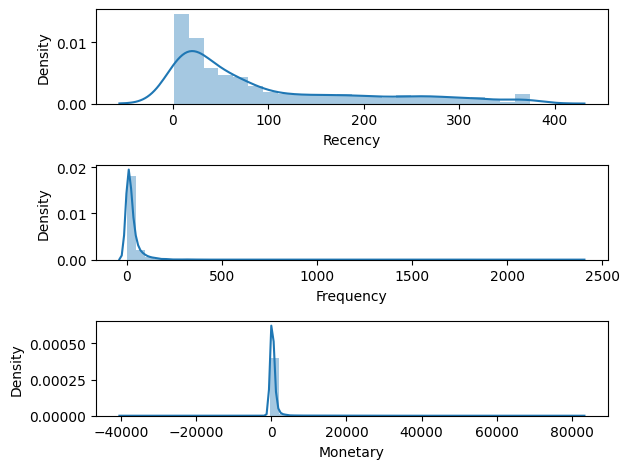

In [ ]:
# plot the distribution of RFM values
plt.subplot(3, 1, 1); sns.distplot(rfm.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm.Monetary, label = 'Monetary')

plt.tight_layout()
plt.show()

As you can see above, the values are skewed and need to be normalized. Due to the zero or negative values in Recency and MonetaryValue, we need to set them 1 before log transformation and scaling.

In [ ]:
# define function for the values below 0
def neg_to_zero(x):
    if x <= 0:
        return 1
    else:
        return x

In [ ]:
# apply the function to Recency and MonetaryValue column
rfm['Recency'] = [neg_to_zero(x) for x in rfm.Recency]
rfm['Monetary'] = [neg_to_zero(x) for x in rfm.Monetary]
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12347.0,3,45,980.10,4,4,4,4.04.04.0,12,Gold
12348.0,249,9,728.88,1,2,4,1.02.04.0,7,Bronze
12349.0,19,25,486.87,3,3,3,3.03.03.0,9,Silver
12350.0,311,3,45.70,1,1,1,1.01.01.0,3,Green
12352.0,37,32,1353.48,3,3,4,3.03.04.0,10,Silver


In [ ]:
# unskew the data
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)
rfm_log.head()


,Recency,Frequency,Monetary
CustomerID,,,
12347.0,1.099,3.807,6.888
12348.0,5.517,2.197,6.592
12349.0,2.944,3.219,6.188
12350.0,5.740,1.099,3.822
12352.0,3.611,3.466,7.210


In [ ]:
rfm_log.describe()

,Recency,Frequency,Monetary
count,4222.000000,4222.000000,4222.000000
mean,3.803762,2.566761,5.303256
std,1.394512,1.258514,1.428801
min,0.000000,0.000000,0.000000
25%,2.890000,1.792000,4.454500
50%,3.941500,2.565000,5.328500
75%,4.997000,3.466000,6.209750
max,5.924000,7.769000,11.313000


<ipython-input-93-2d2716d71144>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(rfm_log.Recency, label = 'Recency')
<ipython-input-93-2d2716d71144>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(rfm_log.Frequency, label = 'Frequency')
<ipython-input

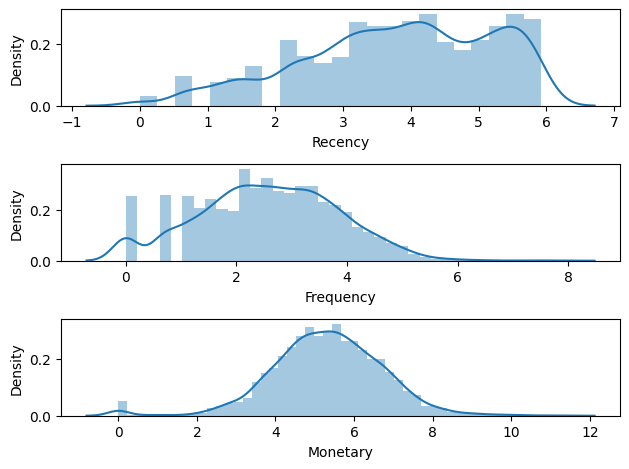

In [ ]:
# plot the distribution of RFM values
plt.subplot(3, 1, 1); sns.distplot(rfm_log.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_log.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_log.Monetary, label = 'Monetary')

plt.tight_layout()
plt.show()

In [ ]:
# scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

In [ ]:
# transform into a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)
rfm_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,-1.939806,0.985595,1.109274
12348.0,1.228703,-0.293843,0.902083
12349.0,-0.616605,0.518322,0.619295
12350.0,1.388635,-1.166403,-1.036835
12352.0,-0.138245,0.714609,1.334664


<ipython-input-96-75fde7d3a551>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(rfm_scaled.Recency, label = 'Recency')
<ipython-input-96-75fde7d3a551>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(rfm_scaled.Frequency, label = 'Frequency')
<ipython

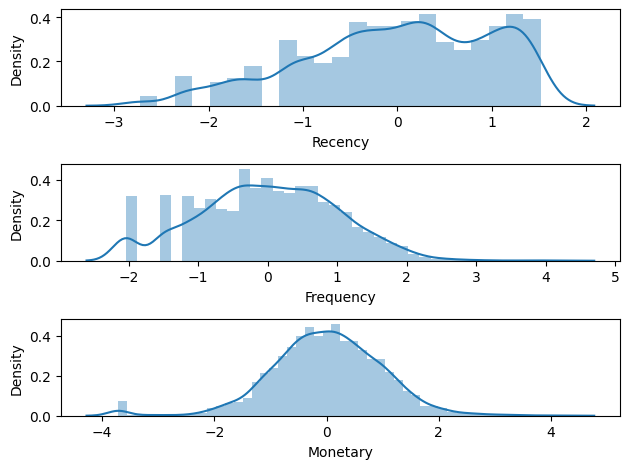

In [ ]:
# plot the distribution of RFM values
plt.subplot(3, 1, 1); sns.distplot(rfm_scaled.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_scaled.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_scaled.Monetary, label = 'Monetary')

plt.tight_layout()
plt.show()

#4-2. K-means clustering

With the Elbow method, we can get the optimal number of clusters.



In [ ]:
# initiate an empty dictionary
wcss = {}

# Elbow method with for loop
for i in range(1, 11):
    kmeans = KMeans(n_clusters= i, init= 'k-means++', max_iter= 300)
    kmeans.fit(rfm_scaled)
    wcss[i] = kmeans.inertia_



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

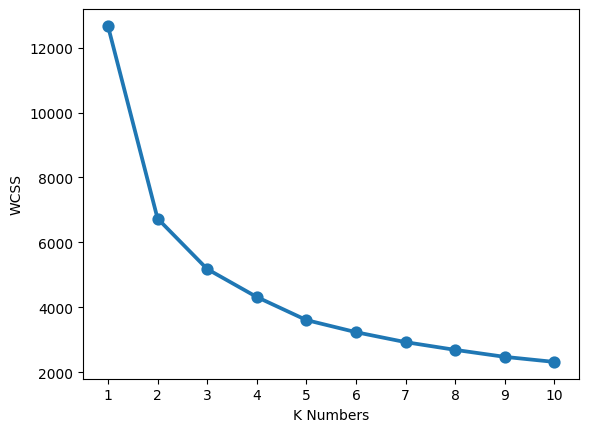

In [ ]:
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# choose n_clusters = 3
clus = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 300)
clus.fit(rfm_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

In [ ]:
# Assign the clusters to datamart
rfm['K_Cluster'] = clus.labels_
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
CustomerID,,,,,,,,,,
12347.0,3,45,980.10,4,4,4,4.04.04.0,12,Gold,1
12348.0,249,9,728.88,1,2,4,1.02.04.0,7,Bronze,0
12349.0,19,25,486.87,3,3,3,3.03.03.0,9,Silver,1
12350.0,311,3,45.70,1,1,1,1.01.01.0,3,Green,2
12352.0,37,32,1353.48,3,3,4,3.03.04.0,10,Silver,1


# 5. Visualization

#5-1. Snake Plot
In marketing, snail plot and heatmap are often used plot for visualization. I'll use the rfm_scaled dataframe with normalized rfm values for the plot.


In [ ]:
# assign cluster column
rfm_scaled['K_Cluster'] = clus.labels_
rfm_scaled['RFM_Level'] = rfm.RFM_Level
rfm_scaled.reset_index(inplace = True)

In [ ]:
rfm_scaled.head()

,CustomerID,Recency,Frequency,Monetary,K_Cluster,RFM_Level
0,12347.0,-1.939806,0.985595,1.109274,1,Gold
1,12348.0,1.228703,-0.293843,0.902083,0,Bronze
2,12349.0,-0.616605,0.518322,0.619295,1,Silver
3,12350.0,1.388635,-1.166403,-1.036835,2,Green
4,12352.0,-0.138245,0.714609,1.334664,1,Silver


In [ ]:
# melt the dataframe
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['CustomerID', 'RFM_Level', 'K_Cluster'],
                     var_name = 'Metrics', value_name = 'Value')
rfm_melted.head()

,CustomerID,RFM_Level,K_Cluster,Metrics,Value
0,12347.0,Gold,1,Recency,-1.939806
1,12348.0,Bronze,0,Recency,1.228703
2,12349.0,Silver,1,Recency,-0.616605
3,12350.0,Green,2,Recency,1.388635
4,12352.0,Silver,1,Recency,-0.138245


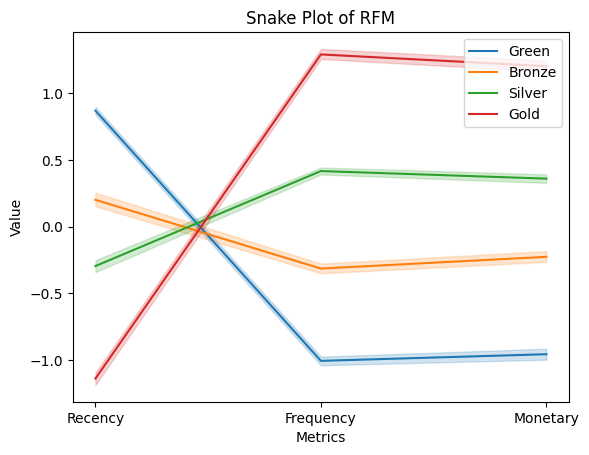

In [ ]:
# a snake plot with RFM
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')


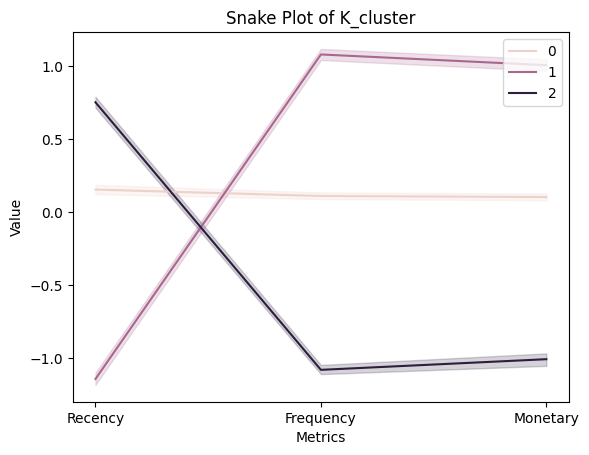

In [ ]:
# a snake plot with K-Means
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster', data = rfm_melted)
plt.title('Snake Plot of K_cluster')
plt.legend(loc = 'upper right')

# 5-2. Heatmap
Heatmap is efficient for comparing the standardized values.

In [ ]:
# the mean value for each cluster
cluster_avg = rfm.groupby('RFM_Level').mean().iloc[:, 0:3]
cluster_avg.head()

<ipython-input-106-3f1c3c6ff7dd>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_avg = rfm.groupby('RFM_Level').mean().iloc[:, 0:3]


,Recency,Frequency,Monetary
RFM_Level,,,
Green,189.634796,4.769592,75.367774
Bronze,94.298088,11.023622,213.655636
Silver,48.358400,26.293600,446.474632
Gold,13.802974,90.825279,2045.677658


In [ ]:
# the mean value in total
total_avg = rfm.iloc[:, 0:3].mean()
total_avg

Recency       94.124112
Frequency     28.907864
Monetary     590.967385
dtype: float64

In [ ]:
# the proportional mean value
prop_rfm = cluster_avg/total_avg - 1
prop_rfm

,Recency,Frequency,Monetary
RFM_Level,,,
Green,1.014731,-0.835007,-0.872467
Bronze,0.001848,-0.618664,-0.638465
Silver,-0.486227,-0.090434,-0.244502
Gold,-0.853353,2.141888,2.461575


[]

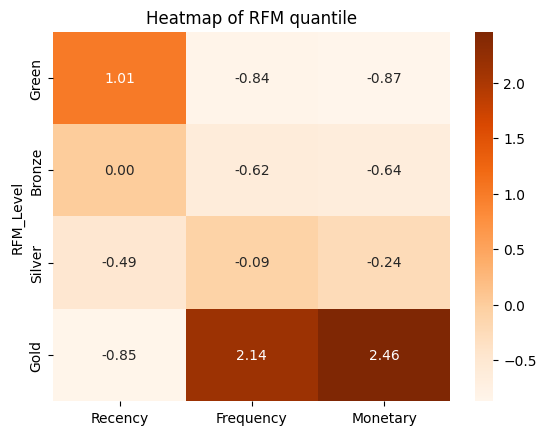

In [ ]:
# heatmap
sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True)
plt.title('Heatmap of RFM quantile')
plt.plot()

In [ ]:
# the mean value for each cluster
cluster_avg_K = rfm.groupby('K_Cluster').mean().iloc[:, 0:3]

# the proportional mean value
prop_rfm_K = cluster_avg_K/total_avg - 1
prop_rfm_K

<ipython-input-111-a05bb358d6be>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_avg_K = rfm.groupby('K_Cluster').mean().iloc[:, 0:3]


,Recency,Frequency,Monetary
K_Cluster,,,
0,-0.110817,-0.356603,-0.463427
1,-0.847654,1.592498,1.799896
2,0.880380,-0.850385,-0.875221


[]

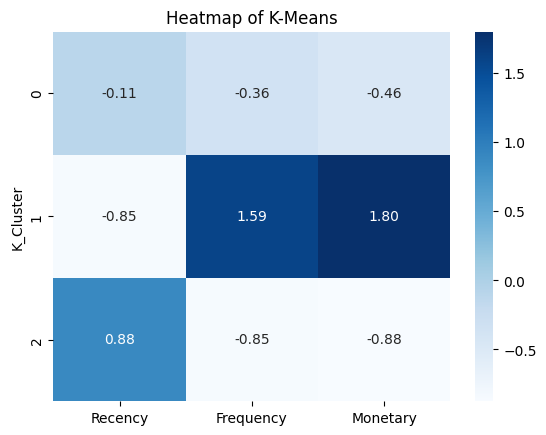

In [ ]:
# heatmap
sns.heatmap(prop_rfm_K, cmap= 'Blues', fmt= '.2f', annot = True)
plt.title('Heatmap of K-Means')
plt.plot()